# Generated conversation repartition

In [9]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

Open the dataset

In [10]:
import jsonlines


# Open the dataset
conversations = []
rd_walk = []
with jsonlines.open("../simulated_conversation.jsonl") as reader:
    for obj in reader:
        conversations.append(obj["conversation"])
        rd_walk.append(obj["random_walk"])

Count state and transition in real generation

In [11]:
# Count each state and transitions appearing in the dataset
state_count_real = {}
transition_count_real = {}
for conv in conversations:
    for turn in conv:
        if "state" in turn.keys():
            state = turn["state"]
            if state not in state_count_real.keys():
                state_count_real[state] = 0
            state_count_real[state] += 1
        if "transition" in turn.keys():
            transition = turn["transition"]
            if transition not in transition_count_real.keys():
                transition_count_real[transition] = 0
            transition_count_real[transition] += 1

del state_count_real["stop"]
del transition_count_real["stop"]

Count state and transition in random walks

In [12]:
# Count each state and transitions appearing in the random walk
state_count_rd = {}
transition_count_rd = {}
for walk in rd_walk:
    for turn in walk:
        state = turn[0]
        if state not in state_count_rd.keys():
            state_count_rd[state] = 0
        state_count_rd[state] += 1
        transition = turn[1]
        if transition not in transition_count_rd.keys():
            transition_count_rd[transition] = 0
        transition_count_rd[transition] += 1

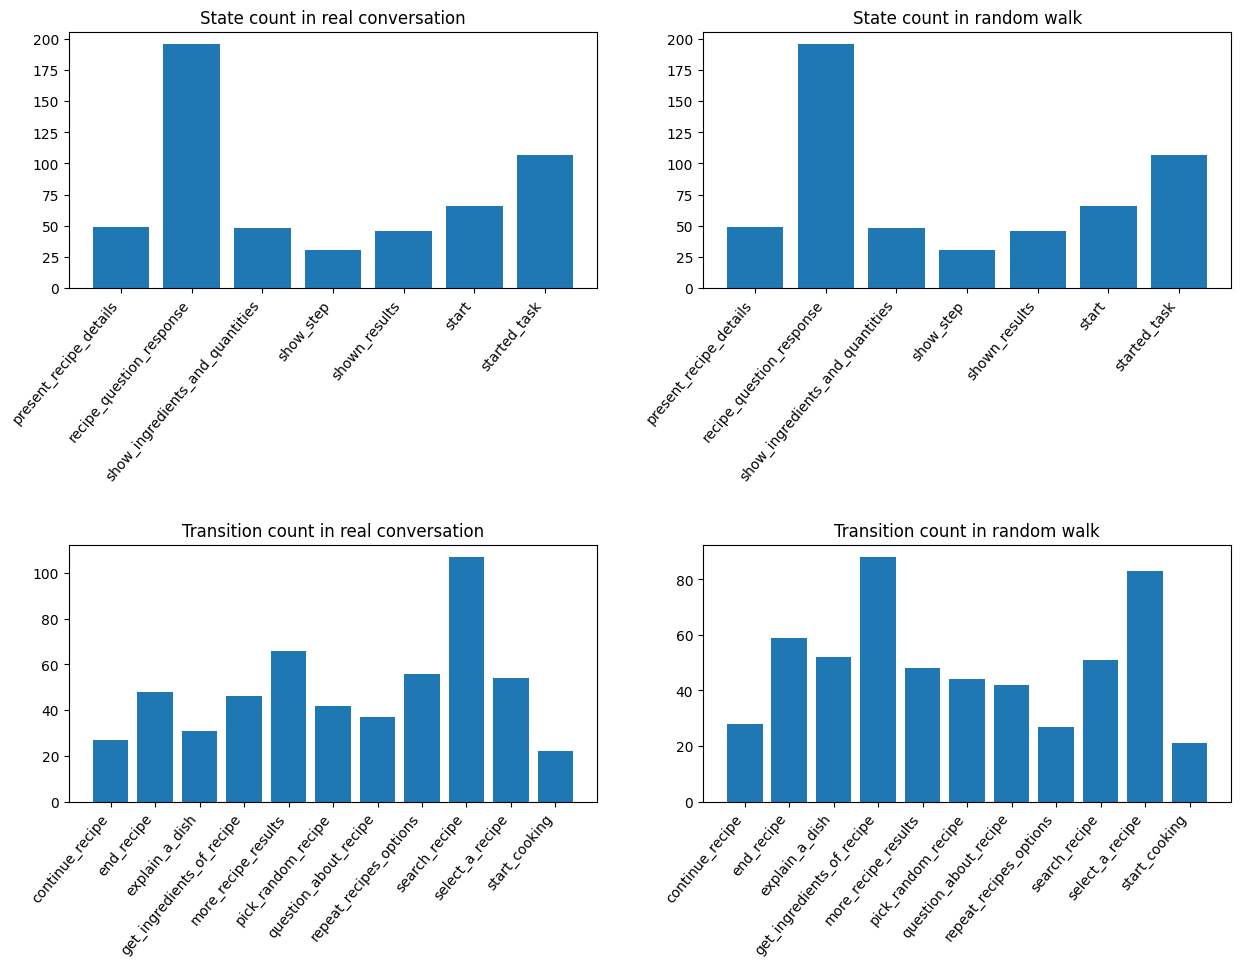

State count in real conversation
{'start': 49, 'shown_results': 196, 'present_recipe_details': 48, 'show_ingredients_and_quantities': 31, 'started_task': 46, 'recipe_question_response': 66, 'show_step': 107}
State count in random walk
{'start': 49, 'shown_results': 196, 'present_recipe_details': 48, 'show_ingredients_and_quantities': 31, 'started_task': 46, 'recipe_question_response': 66, 'show_step': 107}
Transition count in real conversation


In [13]:
import matplotlib.pyplot as plt

# plot the state count and transition count side by side
fig, ax = plt.subplots(
    2, 2, figsize=(15, 10)
)  # Increased figsize to add space between graphs
ax[0, 0].bar(sorted(state_count_real.keys()), state_count_real.values())
ax[0, 0].set_title("State count in real conversation")
plt.sca(ax[0, 0])
plt.xticks(rotation=50, ha="right")

ax[0, 1].bar(sorted(state_count_rd.keys()), state_count_rd.values())
ax[0, 1].set_title("State count in random walk")
plt.sca(ax[0, 1])
plt.xticks(rotation=50, ha="right")

# Added space between graphs
plt.subplots_adjust(hspace=1)  # Adjust the vertical space between subplots

ax[1, 0].bar(sorted(transition_count_real.keys()), transition_count_real.values())
ax[1, 0].set_title("Transition count in real conversation")
plt.sca(ax[1, 0])
plt.xticks(rotation=50, ha="right")

ax[1, 1].bar(sorted(transition_count_rd.keys()), transition_count_rd.values())
ax[1, 1].set_title("Transition count in random walk")
plt.sca(ax[1, 1])
plt.xticks(rotation=50, ha="right")

plt.show()

# Print the state and transition count
print("State count in real conversation")
print(state_count_real)
print("State count in random walk")
print(state_count_rd)
print("Transition count in real conversation")

### Probability of transition in generation

In [14]:
from tqdm import tqdm
from objects.recipe_machine import RecipeMachine

# Compute, for each state, the probability of taking each transition
# Create a nested dictionary to store the count of each transition from each state
sm = RecipeMachine()
state_transition_count = {
    state: {transition: 0 for transition in sm.transitions_graph[state].keys()}
    for state in sm.transitions_graph.keys()
}

# Count the transitions from each state
for conv in tqdm(conversations):
    for i, turn in enumerate(conv):
        if "state" in turn.keys():
            state = turn["state"]
            if state == "stop":
                continue
            if state not in state_transition_count.keys():
                state_transition_count[state] = {}
            transition = conv[i + 1]["transition"]
            if transition == "stop":
                continue
            if transition not in state_transition_count[state].keys():
                state_transition_count[state][transition] = 0
            state_transition_count[state][conv[i + 1]["transition"]] += 1

# Compute the probability of each transition from each state
state_transition_prob = {state: {} for state in sm.transitions_graph.keys()}
for state, transitions in state_transition_count.items():
    total_transitions = sum(transitions.values())
    for transition, count in transitions.items():
        state_transition_prob[state][transition] = count / total_transitions

100%|██████████| 49/49 [00:00<00:00, 43285.78it/s]


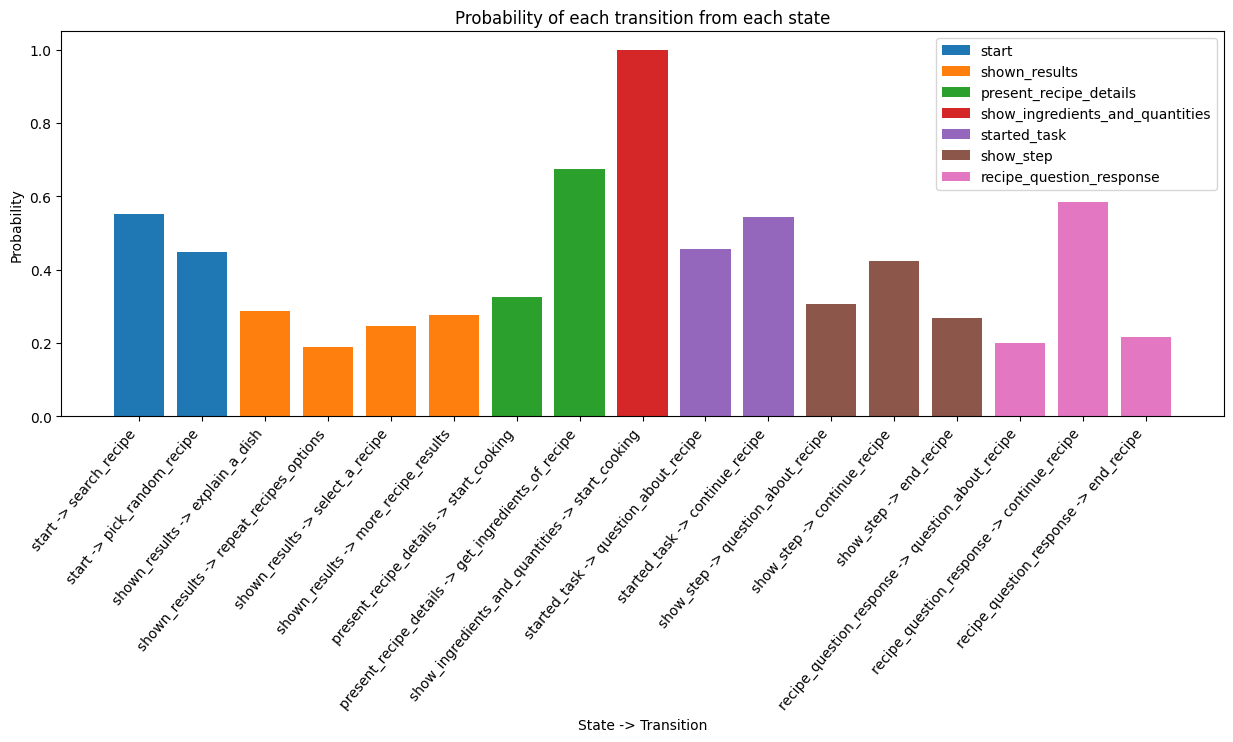

In [15]:
# Plot the probability of each transition from each state
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for state, transitions in state_transition_prob.items():
    ax.bar(
        [f"{state} -> {transition}" for transition in transitions.keys()],
        transitions.values(),
        label=state,
    )
ax.set_title("Probability of each transition from each state")
ax.set_xlabel("State -> Transition")
ax.set_ylabel("Probability")
plt.xticks(
    rotation=50, ha="right"
)  # Apply rotation to x-axis labels of the subplot and align them to the right
plt.legend()
plt.show()